In [1]:
import os, csv,sys
import io, textwrap, itertools
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
csv.field_size_limit(sys.maxsize)


common_nucleotide_set = {'A', 'T', 'C', 'G', 'U', 'N'}

# not {'O', 'U', 'Z', 'J', 'B'}
# Common amino acids
common_amino_acid_set = {'R', 'X', 'S', 'G', 'W', 'I', 'Q', 'A', 'T', 'V', 'K', 'Y', 'C', 'N', 'L', 'F', 'D', 'M', 'P', 'H', 'E'}


def clean_seq(protein_id, seq):
    seq = seq.upper()
    new_seq = ""
    has_invalid_char = False
    invalid_char_set = set()
    for ch in seq:
        if 'A' <= ch <= 'Z' and ch not in ['J']:
            new_seq += ch
        else:
            invalid_char_set.add(ch)
            has_invalid_char = True
    if has_invalid_char:
        print("id: %s. Seq: %s" % (protein_id, seq))
        print("invalid char set:", invalid_char_set)
    return new_seq


def file_reader(filename, header=True, header_filter=True):
    if filename.endswith(".fa") or filename.endswith(".fas") or filename.endswith(".fasta"):
        return fasta_reader(filename)
    elif filename.endswith(".csv"):
        return csv_reader(filename, header=True, header_filter=True)
    elif filename.endswith(".tsv"):
        return tsv_reader(filename, header=True, header_filter=True)
    else:
        return txt_reader(filename, header=header, header_filter=header_filter)


def txt_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        cnt = 0
        for line in handle:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield line.strip()
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def tsv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        reader = csv.reader(handle, delimiter="\t")
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def csv_reader(handle, header=True, header_filter=True):
    '''
    csv 读取器，适合大文件
    :param handle:
    :param header:
    :param header_filter: 返回结果是否去掉头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    try:
        # data = csv.reader((line.replace('\0','') for line in data_initial), delimiter=",")
        # reader = csv.reader(handle)
        reader = csv.reader((line.replace('\0', '') for line in handle))
        cnt = 0
        for row in reader:
            cnt += 1
            if header and header_filter and cnt == 1:
                continue
            yield row
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def txt_writer(dataset, handle, header=None):
    '''
    txt 写
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        if header:
            if isinstance(header, list):
                handle.write(",".join(header) + "\n")
            else:
                handle.write(header + "\n")
        print("header: %s" %header)
        for row in dataset:
            handle.write(str(row) + "\n")
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()
    '''
    with open(handle, "w") as wfp:
        if header:
            if isinstance(header, list):
                wfp.write(",".join(header) + "\n")
            else:
                wfp.write(header + "\n")
        for row in dataset:
            wfp.write(str(row) + "\n")


def csv_writer(dataset, handle, header):
    '''
    csv 写，适合大文件
    :param dataset: 数据
    :param handle: 文件
    :param header: 头
    :return:
    '''
    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'w')
    try:
        writer = csv.writer(handle)
        if header:
            writer.writerow(header)
        for row in dataset:
            writer.writerow(row)
    except Exception as e:
        raise e
    finally:
        if not handle.closed:
            handle.close()


def fasta_reader(handle, width=None):
    """
    Reads a FASTA file, yielding header, sequence pairs for each sequence recovered 适合大文件
    args:
        :handle (str, pathliob.Path, or file pointer) - fasta to read from
        :width (int or None) - formats the sequence to have max `width` character per line.
                               If <= 0, processed as None. If None, there is no max width.
    yields:
        :(header, sequence) tuples
    returns:
        :None
    """
    FASTA_STOP_CODON = "*"

    handle = handle if isinstance(handle, io.TextIOWrapper) else open(handle, 'r')
    width = width if isinstance(width, int) and width > 0 else None
    try:
        header = None
        for is_header, group in itertools.groupby(handle, lambda line: line.startswith(">")):
            if is_header:
                header = group.__next__().strip()
            else:
                seq = ''.join(line.strip() for line in group).strip().rstrip(FASTA_STOP_CODON)
                if width is not None:
                    seq = textwrap.fill(seq, width)
                yield header, seq
    except Exception as e:
        raise StopIteration
    finally:
        if not handle.closed:
            handle.close()


def write_fasta(filepath, sequences):
    '''
    write fasta file
    :param filepath: savepath
    :param sequences: fasta sequence(each item: [id, seq])
    :return:
    '''

    if sequences:
        with open(filepath, "w") as output_handle:
            if len(sequences[0]) > 1 and isinstance(sequences[0][0], str):
                for row in sequences:
                    protein_id = row[0]
                    seq = row[1]
                    sequence = SeqRecord(Seq(seq, None), id=protein_id[1:] if protein_id and protein_id[0] == ">" else protein_id, description="")
                    SeqIO.write(sequence, output_handle, "fasta")
            else:
                for sequence in sequences:
                    SeqIO.write(sequence, output_handle, "fasta")


In [2]:
query_seq_ids = set()
for row in fasta_reader("./fasta/lucapcycle_cold_spring_ori_positives.fasta"):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    query_seq_ids.add(seq_id)
print("query_seq_ids: %d" % len(query_seq_ids))

target_seq_ids = set()
for row in fasta_reader("./fasta/lucapcycle_cold_spring_ori_positives.fasta"):
    seq_id = row[0]
    if seq_id[0] == ">":
        seq_id = seq_id[1:]
    target_seq_ids.add(seq_id)
print("target_seq_ids: %d" % len(target_seq_ids))

query_seq_ids: 214193
target_seq_ids: 214193


In [3]:
query_seq_id_set = set()
target_seq_id_set = set()
query_seq_id_sim = {}
min_sim = 1.0
max_sim = 0.0
for row in tsv_reader(
    "./fasta/diamond_against/lucapcycle_lucapcycle_cold_spring_ori_positives_against_lucapcycle_cold_spring_ori_positives.tsv",
    header=True, 
    header_filter=True
):
    query_seq_id, target_seq_id, sim = row[0], row[2], float(row[5])/100
    if query_seq_id == target_seq_id:
        continue
    query_seq_id_set.add(query_seq_id)
    target_seq_id_set.add(target_seq_id)
    if query_seq_id not in query_seq_id_sim or sim > query_seq_id_sim[query_seq_id]:
        query_seq_id_sim[query_seq_id] = sim
    if sim < min_sim:
        min_sim = sim
    if sim > max_sim:
        max_sim = sim
print("query_seq_id_set: %d" % len(query_seq_id_set))
print("target_seq_id_set: %d" % len(target_seq_id_set))
print("min sim: %f" % min_sim)
print("max sim: %f" % max_sim)

query_seq_id_set: 214188
target_seq_id_set: 189680
min sim: 0.224000
max sim: 1.000000


In [4]:
print(len(query_seq_id_set & query_seq_ids))
print(len(target_seq_id_set & target_seq_ids))

214188
189680


In [5]:
sim_values = list(query_seq_id_sim.values())

sim_section_names = [
    "(, 0.2)", 
    "[0.2, 0.3)",
    "[0.3, 0.4)", 
    "[0.4, 0.5)", 
    "[0.5, 0.6)", 
    "[0.6, 0.7)",
    "[0.7, 0.8)",
    "[0.8, 0.9)",
    "[0.9, 1.0)",
    "=1.0"
]
sim_section = [0] * len(sim_section_names)
for sim in sim_values:
    if sim < 0.2:
        idx = 0
    elif sim < 0.3:
        idx = 1
    elif sim < 0.4:
        idx = 2
    elif sim < 0.5:
        idx = 3
    elif sim < 0.6:
        idx = 4
    elif sim < 0.7:
        idx = 5
    elif sim < 0.8:
        idx = 6
    elif sim < 0.9:
        idx = 7
    elif sim < 1.0:
        idx = 8
    else:
        idx = 9
    sim_section[idx] += 1
sim_section[0] += (len(query_seq_ids) - len(sim_values))
for idx, name in enumerate(sim_section_names):
    print("%s:%d" % (name, sim_section[idx]))
    

(, 0.2):5
[0.2, 0.3):13
[0.3, 0.4):619
[0.4, 0.5):3055
[0.5, 0.6):8219
[0.6, 0.7):15934
[0.7, 0.8):26800
[0.8, 0.9):46153
[0.9, 1.0):112858
=1.0:537


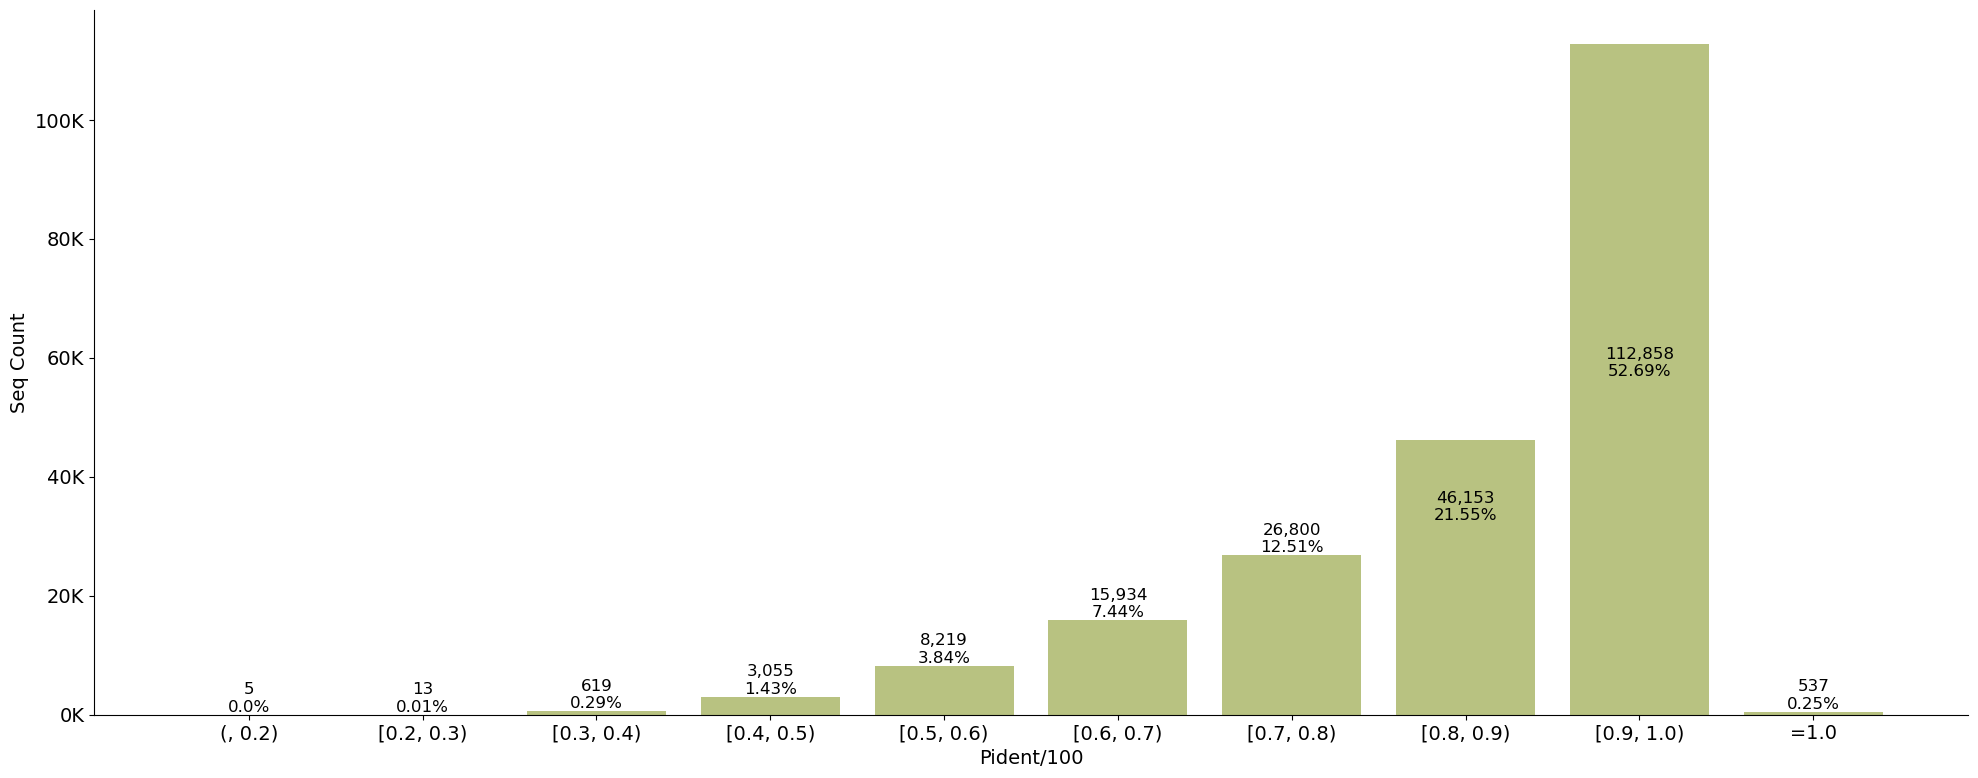

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['font.size'] = 14

if not os.path.exists("./pic/"):
    os.makedirs("./pic/")

# 数据准备
categories = sim_section_names
values = sim_section
sum_value = sum(values)

plt.figure(figsize=(20, 8))

# 绘制柱状图
plt.bar(categories, values, color='#b8c281')

for i, value in enumerate(values):
    if i == len(values) - 2:
        y = max(values) / 2
    else:
        y =  min(max(values)/3.5, value)
    plt.text(
        i, 
        y, 
        f"{value:,}" + "\n" + str(round(100 * value/sum_value, 2)) + "%", 
        ha='center', 
        va='bottom',
        fontsize=12
    )

# 添加标题和标签
# plt.title('Similarity Distribution')
plt.xlabel('Pident/100')
plt.ylabel('Seq Count')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 定义格式化函数
def thousands_formatter(x, pos):
    return f'{int(x/1000)}K'

# 应用格式化到y轴
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

# 调整布局防止重叠
plt.tight_layout()  

# 显示图形
plt.savefig("./pic/Fig.LucaPcycle_Positives_Against_Positives.png", dpi=600,  format='png')
plt.savefig("./pic/Fig.LucaPcycle_Positives_Against_Positives.pdf", dpi=600,  format='pdf')

In [7]:
accumulated_value = 0
for idx, value in enumerate(sim_section):
    accumulated_value += value
    print("categories: %s" % categories[idx])
    print("accumulated_value: %d" % accumulated_value)
    print("accumulated_rate: %d/%d=%.4f" %(accumulated_value, sum_value, accumulated_value/sum_value))

categories: (, 0.2)
accumulated_value: 5
accumulated_rate: 5/214193=0.0000
categories: [0.2, 0.3)
accumulated_value: 18
accumulated_rate: 18/214193=0.0001
categories: [0.3, 0.4)
accumulated_value: 637
accumulated_rate: 637/214193=0.0030
categories: [0.4, 0.5)
accumulated_value: 3692
accumulated_rate: 3692/214193=0.0172
categories: [0.5, 0.6)
accumulated_value: 11911
accumulated_rate: 11911/214193=0.0556
categories: [0.6, 0.7)
accumulated_value: 27845
accumulated_rate: 27845/214193=0.1300
categories: [0.7, 0.8)
accumulated_value: 54645
accumulated_rate: 54645/214193=0.2551
categories: [0.8, 0.9)
accumulated_value: 100798
accumulated_rate: 100798/214193=0.4706
categories: [0.9, 1.0)
accumulated_value: 213656
accumulated_rate: 213656/214193=0.9975
categories: =1.0
accumulated_value: 214193
accumulated_rate: 214193/214193=1.0000
